In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [2]:
np.random.seed(0)
c= 3e8


lambda_0= 1550e-9
wl_single = 1550e-9    #single line
amp_single = 1.0       #amplitude of single line
sigma_m = 0.005e-9     #width of the single line

unknown_wavelengths = np.array([1549e-9, 1550e-9, 1551e-9])
amplitudes = np.array([1.0, 0.7, 0.5])


OPD_max = 0.08                
OPD_total = 2 * OPD_max

delta_opd = lambda_0 / 4.0
N = int(np.ceil(OPD_total / delta_opd)) + 1
OPD = np.linspace(-OPD_max, OPD_max, N)


print(f"Single-line: OPD span = {OPD_total:.4f} m, samples = {N}, delta_opd = {delta_opd*1e6:.3f} µm")


Single-line: OPD span = 0.1600 m, samples = 412905, delta_opd = 0.388 µm


In [3]:
def generate_interferogram(wavelengths, amplitudes,OPD):       
    I = np.zeros_like(OPD)
    for wl, amp in zip(wavelengths, amplitudes):
        I += amp * np.cos(2.0 * np.pi * OPD / wl)
    return I / np.max(np.abs(I))

interf_single = generate_interferogram([wl_single], [amp_single], OPD)

interf_combined = generate_interferogram(unknown_wavelengths, amplitudes, OPD)

def add_noise(sig, noise_level=0.0):
    if noise_level <= 0:
        return sig
    shot = np.random.normal(0, noise_level, size=sig.shape)
    elec = np.random.normal(0, noise_level/2, size=sig.shape)
    return sig + shot + elec

interf_single_noisy = add_noise(interf_single, noise_level=0.01)

interf_combined_noisy = add_noise(interf_combined, noise_level=0.02)




In [4]:
def recover_spectrum(interferogram, OPD, remove_dc=True, apod_window=None, zff=0):
    x = interferogram.copy().astype(float)
    delta = OPD[1] - OPD[0]
    N = len(x)
    if apod_window is not None:
        x *= apod_window(N)
    if remove_dc:
        x -= np.mean(x)
    target_N = N * (2**zff)
    if target_N > N:
        x = np.pad(x, (0, target_N - N), mode='constant')
        N = len(x)
    X = np.fft.fft(x)
    freqs = np.fft.fftfreq(N, d=delta)   # cycles per meter (1/m)
    pos = freqs > 0
    freqs_pos = freqs[pos]
    S_pos = np.abs(X[pos])
    wavelengths = 1.0 / freqs_pos        # meters
    order = np.argsort(wavelengths)
    wavelengths_sorted = wavelengths[order]
    S_sorted = S_pos[order]
    S_sorted /= np.max(S_sorted)
    return wavelengths_sorted, S_sorted


def average_recovery(interf, OPD, n_scans=10, noise_level=0.02, apod_window=np.hanning, zff=1):
    acc = None
    lam_axis = None
    for _ in range(n_scans):
        noisy = add_noise(interf, noise_level=noise_level)
        lam, spec = recover_spectrum(noisy, OPD, apod_window=apod_window, zff=zff)
        if acc is None:
            acc = spec.copy()
            lam_axis = lam.copy()
        else:
            acc += spec
    acc /= n_scans
    acc /= np.max(acc)
    return lam_axis, acc

In [5]:
lam_rec, spec_rec = recover_spectrum(interf_single_noisy, OPD, apod_window=np.hanning, zff=1)
lam_rec_1, spec_rec_1 = average_recovery(interf_combined_noisy, OPD, n_scans=8, noise_level=0.02, apod_window=np.hanning, zff=1)
#lam_rec_1, spec_rec_1 = recover_spectrum(interf_combined_noisy, OPD,  apod_window=np.hanning, zff=1)

In [6]:
lam_plot = np.linspace(wl_single - 0.5e-9, wl_single + 0.5e-9, 2000)
true_spec = np.exp(-((lam_plot - wl_single) / sigma_m)**2)
true_spec /= true_spec.max()

lam_plot_1 = np.linspace(1548.0e-9, 1552.0e-9, 4000)
true_spec_1 = np.zeros_like(lam_plot_1)
for wl, amp in zip(unknown_wavelengths, amplitudes):
    true_spec_1 += amp * np.exp(-((lam_plot_1 - wl) / sigma_m) ** 2)
true_spec_1 /= np.max(true_spec_1)


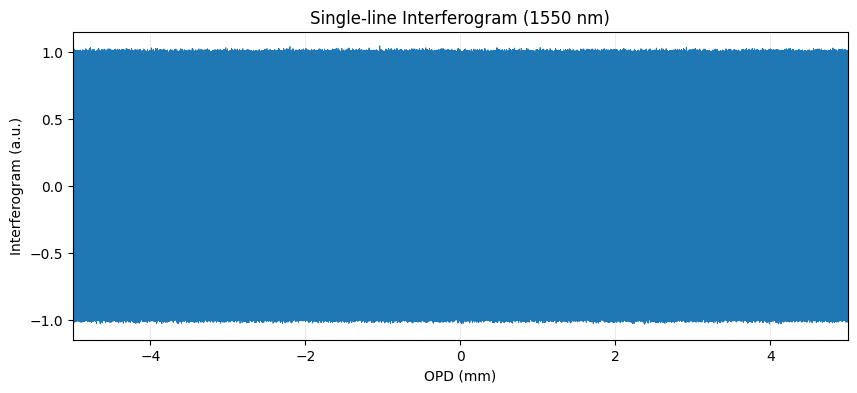

In [7]:
plt.figure(figsize=(10,4))
plt.plot(OPD*1e3, interf_single_noisy, linewidth=0.6)
plt.xlim(-5, 5)   # show ±5 mm around ZPD — adjust as desired
plt.xlabel("OPD (mm)")
plt.ylabel("Interferogram (a.u.)")
plt.title("Single-line Interferogram (1550 nm)")
plt.grid(alpha=0.25)
plt.savefig("Interferogram of Single Line (1550nm)")
plt.show()

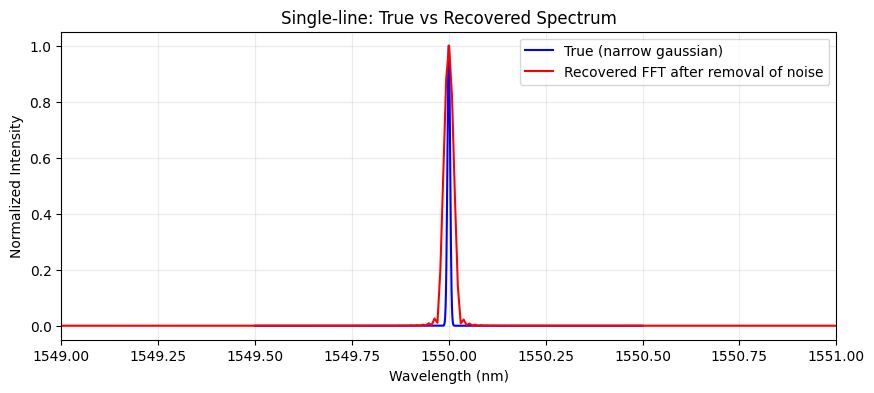

In [8]:
plt.figure(figsize=(10,4))
plt.plot(lam_plot*1e9, true_spec, label="True (narrow gaussian)",color="blue")
plt.plot(lam_rec*1e9, spec_rec, label="Recovered FFT after removal of noise",color="red")
plt.xlim((wl_single*1e9)-1.0, (wl_single*1e9)+1.0)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Normalized Intensity")
plt.title("Single-line: True vs Recovered Spectrum")
plt.legend()
plt.grid(alpha=0.25)
plt.savefig("recovered single-line")
plt.show()

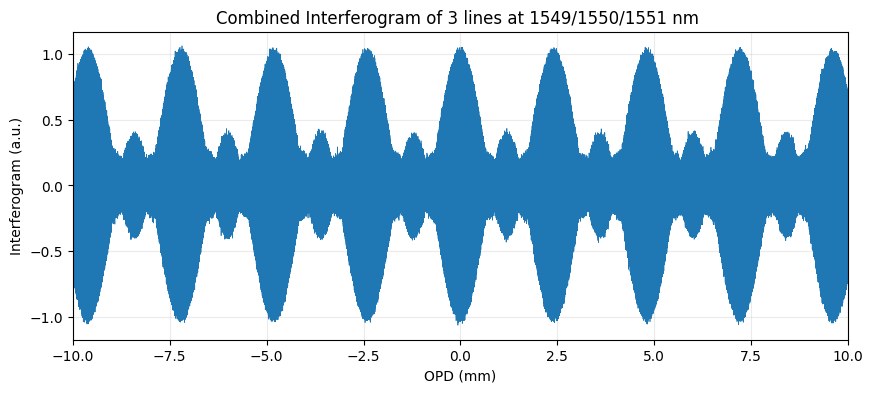

In [9]:
plt.figure(figsize=(10,4))
plt.plot(OPD*1e3, interf_combined_noisy, linewidth=0.5)
plt.xlim(-10, 10)   # show ±10 mm around ZPD for clarity
plt.xlabel("OPD (mm)")
plt.ylabel("Interferogram (a.u.)")
plt.title("Combined Interferogram of 3 lines at 1549/1550/1551 nm ")
plt.grid(alpha=0.25)
plt.savefig("combined interferogram")
plt.show()

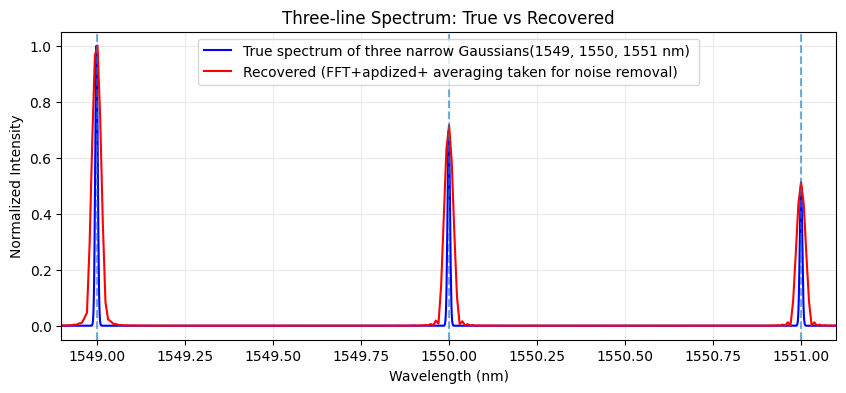

In [10]:
plt.figure(figsize=(10,4))
plt.plot(lam_plot_1*1e9, true_spec_1, label="True spectrum of three narrow Gaussians(1549, 1550, 1551 nm) ",color="blue")
plt.plot(lam_rec_1*1e9, spec_rec_1, label="Recovered (FFT+apdized+ averaging taken for noise removal)", color="red")
# mark true lines
for wl in unknown_wavelengths:
    plt.axvline(wl*1e9, linestyle='--', alpha=0.6)
plt.xlim(1548.9, 1551.1)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Normalized Intensity")
plt.title("Three-line Spectrum: True vs Recovered")
plt.legend()
plt.grid(alpha=0.25)
plt.savefig("Three-line Spectrum_True vs Recovered")
plt.show()

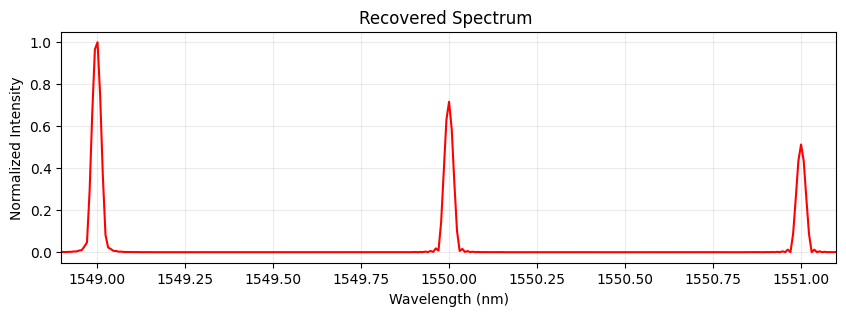

In [11]:
plt.figure(figsize=(10,3))
plt.plot(lam_rec_1*1e9, spec_rec_1,color="red")
plt.xlim(1548.9, 1551.1)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Normalized Intensity")
plt.title("Recovered Spectrum ")
plt.grid(alpha=0.25)
plt.savefig("Recovered Spectrum")
plt.show()